## Pre-trained model usage

### Importing an existing deep learning model for image classification

In [1]:
# The model for the skin cancer classifier

# Importing the libraries
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [2]:
# Checking if GPU is available
import tensorflow as tf
tf.test.is_built_with_cuda()

True

In [3]:
# Accessing Google drive from where directories shall be accessed and created
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# The paths for the training and validation images
train_path = 'drive/MyDrive/base_dir/train_dir'
valid_path = 'drive/MyDrive/base_dir/val_dir'

In [5]:
# Declaring a few useful values
num_train_samples = 9013
num_val_samples = 1002
train_batch_size = 32
val_batch_size = 32
image_size = 224

In [6]:
# Declaring how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [7]:
# Setting up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=train_batch_size)

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False)

Found 38704 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [8]:
# Initialising a MobileNet pre-trained model from Keras and passing it to model object
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# Making sure to exclude the top part and setting the input shape of the model to 224x224 pixels, with 3 color channels.
mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
# Displaying a summary of the layers in the model
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Transfer learning

### Modifying MobileNet model architecture to retrain it on the data

The **MobileNet pre-trained model** has millions of connections that has already been trained on a large data set. It is reliable at identifying different features hence there is **only a need to retrain a part of it** by 'freezing' its first few layers. **After adding a fully connected layer and through only training the last few layers, a 'new' model is obtained** that can effectively identify basic features and make predictions on relevant new data.

In [10]:
# Modifying the model
# Excluding the last 5 layers of the model
x = mobile.layers[-6].output
# Adding a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

In [11]:
# Creating a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)

In [12]:
# Seeing a summary of the new layers in the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [13]:
# Further customising the model to include a top classifier that fits the target expected
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(7, activation='sigmoid'))

# Getting the summary of the new model
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 7)           1541511   
                                                                 
 flatten (Flatten)           (None, 343)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                22016     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 1,563,982
Trainable params: 1,533,070
Non-trainable params: 30,912
_________________________________________________________________


### Training the new model

In [14]:
# Training the model
# Defining Top2 and Top3 Accuracy
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [15]:
# Compiling the model
new_model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# Adding weights to make the model more sensitive to melanoma, which is a type of skin cancer
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 3.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Declaring the filepath for the saved model
filepath = "drive/MyDrive/new_model.h5"

In [17]:
# Declaring a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

In [18]:
# Reducing the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

In [19]:
# Compiling and fitting the model. Use the Adam optimizer and crossentropical loss. 
# Using the validation data argument during fitting to include your validation data.
new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
history = new_model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=10,
                              verbose=1,
                              callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
282/282 [==============================] - 3130s 11s/step - loss: 1.6925 - accuracy: 0.4479 - val_loss: 2.8421 - val_accuracy: 0.1637 - lr: 0.0010
Epoch 2/10
282/282 [==============================] - 2135s 8s/step - loss: 1.4200 - accuracy: 0.5343 - val_loss: 3.8082 - val_accuracy: 0.1088 - lr: 0.0010
Epoch 3/10
282/282 [==============================] - 1687s 6s/step - loss: 1.2986 - accuracy: 0.5768 - val_loss: 5.1214 - val_accuracy: 0.0230 - lr: 0.0010
Epoch 4/10
282/282 [==============================] - 1554s 5s/step - loss: 1.2264 - accuracy: 0.6090 - val_loss: 5.5206 - val_accuracy: 0.0689 - lr: 0.0010
Epoch 5/10
282/282 [==============================] - 1570s 6s/step - loss: 1.1559 - accuracy: 0.6313 - val_loss: 5.4511 - val_accuracy: 0.1058 - lr: 0.0010
Epoch 6/10
282/282 [==============================] - 1546s 5s/step - loss: 1.0832 - accuracy: 0.6541 - val_loss: 7.1677 - val_accuracy: 0.0559 - lr: 0.0010
Epoch 7/10
282/282 [==============================] - 154

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Saving the model that was just pre-trained using TensorFlow SavedModel format
import numpy as np
import tensorflow as tf
from tensorflow import keras

new_model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


In [24]:
#### Loading and reconstructing the model identically
reconstructed_model = keras.models.load_model("my_model")

In [25]:
### Checking reconstruction of saved model:
np.testing.assert_allclose(
    model.predict(test_input), reconstructed_model.predict(test_input)
)

NameError: ignored

In [26]:
# Evaluating the model ### OR reconstructed_model from new_model
# Evaluation of the last epoch
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
reconstructed_model.evaluate_generator(test_batches, steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: ignored

In [27]:
# Printing of the best results
print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

NameError: ignored

In [28]:
# Evaluation of the best epoch ### OR reconstructed_model from new_model
new_model.load_weights('new_model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
reconstructed_model.evaluate_generator(test_batches, steps=val_steps)
# Printing of the best results
print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

OSError: ignored

In [29]:
# Creating a confusion matrix of the test images
test_labels = test_batches.classes

In [30]:
# Make predictions ### OR reconstructed_model from new_model
predictions = reconstructed_model.predict_generator(test_batches, steps=val_steps, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


32/32 [==============================] - 35s 988ms/step


Confusion matrix, without normalization
[[  0   0   0   0  32   0   1]
 [  0   1   0   0  44   3   3]
 [  0   0   0   0 102   4   4]
 [  0   0   0   0  10   0   2]
 [  0   0   0   0 105   4   2]
 [  0   1   0   0 328 324  18]
 [  0   0   0   0   2   1  11]]


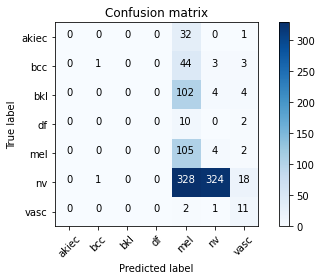

In [31]:
# Declaring a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)